In [1]:
import plotnine
import pandas as pd
import numpy as np
from tqdm import tqdm
from plotnine import *
time_format = "%Y-%m-%d"

In [2]:
root_path = "../generated_data/final_1000/"
def get_result_path(method: str):
    return root_path + method + "/"

start_date = "2022-06-01"
end_date = "2022-10-29"

In [3]:
true_price_df = pd.read_csv("true_product_price.csv")
true_price_df = true_price_df.assign(date = lambda x:  pd.to_datetime(x.Dates, format = "%d/%m/%Y")).drop(columns = "Dates").set_index("date")
true_price_df.rename(columns = {"PX_LAST": "true_price"}, inplace = True)

In [4]:
def generate_path_df(result_path: str, start_date: str = start_date, end_date: str = start_date):
    date_to_v_0 = {}
    for cur_date in tqdm(pd.bdate_range("2022-05-31", "2022-10-31")): # "2022-05-31", "2022-08-15", "2022-10-31"
        cur_date = (cur_date + pd.Timedelta(days = 1)).strftime(time_format)
        sim_df = pd.read_csv(result_path + cur_date + "v_0" + ".csv", names = ["index", "price"], header=1)
        date_to_v_0[cur_date] = sim_df
    sim_price_path = [[date, prices["price"].mean(),  prices["price"].std()] for date, prices in date_to_v_0.items()]

    return (
        (pd.DataFrame(sim_price_path, columns = ["date", "price", "STD"]).set_index("date") / 5000 * 100)
        .assign(
            price_lower = lambda x: x.price - 1.645 * x.STD,
            price_upper = lambda x: x.price + 1.645 * x.STD,
            true_price = true_price_df["true_price"]
        ).fillna(method = "ffill")
        )

In [5]:
def plot(df, title):
    return (
    ggplot() 
    + geom_ribbon(aes(x = "date", ymax = "price_upper", ymin = "price_lower"), data = df, fill = "#a9bad6", alpha = 0.5)
    + geom_line(aes(x="date", y="price"), show_legend = True, data = df, color = "#0745b0")
     + geom_line(aes(x="date", y="true_price"),data = df, show_legend = True, color = "#000000")
     +labs(title = title)
    )

## MC

100%|██████████| 110/110 [00:00<00:00, 601.10it/s]


(<AxesSubplot:xlabel='date'>, 22.849586373203834, 8.910227602765037)

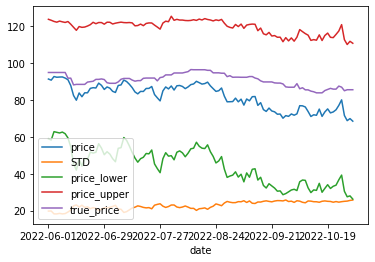

In [6]:
df = generate_path_df(get_result_path("mc"))
df.plot(), df.STD.mean(), np.sqrt((df["price"] - df["true_price"]) ** 2).mean()

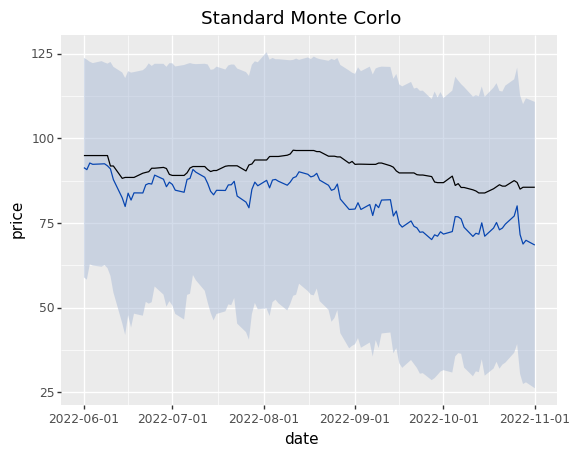

<ggplot: (171907677085)>

In [7]:
df.reset_index(inplace=True)
df["date"] = pd.to_datetime(df["date"])
plot(df, "Standard Monte Corlo")

## AV

100%|██████████| 110/110 [00:02<00:00, 40.24it/s]


(<AxesSubplot:xlabel='date'>, 22.876943373746382, 10.054925477893345)

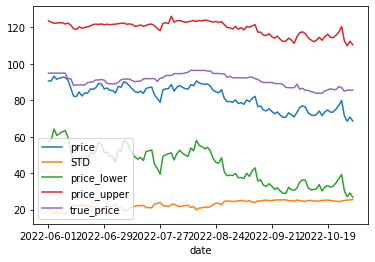

In [8]:
df = generate_path_df(get_result_path("av"))
df.plot(), df.STD.mean(), np.sqrt(((df["price"] - df["true_price"]) ** 2).mean())

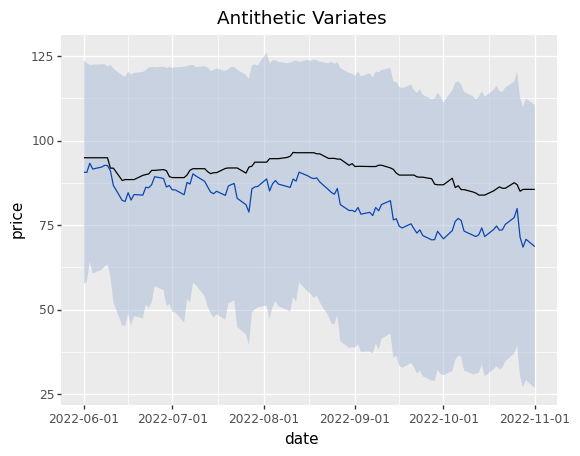

<ggplot: (171907754481)>

In [9]:
df.reset_index(inplace=True)
df["date"] = pd.to_datetime(df["date"])
plot(df, "Antithetic Variates")

## SS

100%|██████████| 110/110 [00:01<00:00, 66.04it/s]


(<AxesSubplot:xlabel='date'>, 22.92669710930606, 10.020421379163011)

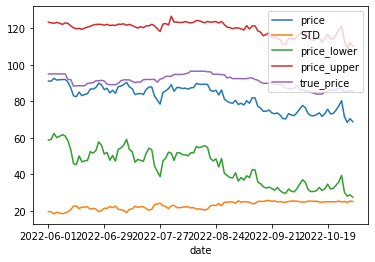

In [10]:
df = generate_path_df(get_result_path("ss"))
df.plot(), df.STD.mean(), np.sqrt(((df["price"] - df["true_price"]) ** 2).mean())

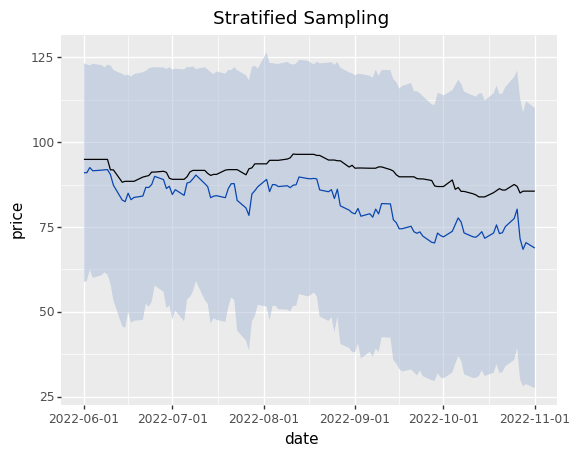

<ggplot: (171907942503)>

In [11]:
df.reset_index(inplace=True)
df["date"] = pd.to_datetime(df["date"])
plot(df, "Stratified Sampling")